# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [3]:
import pandas as pd

google_price = pd.read_csv('./google_price.csv')
google_price.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,736.789978,738.989990,732.500000,733.530029,733.530029,1301300
1,2016-03-29,734.590027,747.250000,728.760010,744.770020,744.770020,1903800
2,2016-03-30,750.099976,757.880005,748.739990,750.530029,750.530029,1782400
3,2016-03-31,749.250000,750.849976,740.940002,744.950012,744.950012,1718800
4,2016-04-01,738.599976,750.340027,737.000000,749.909973,749.909973,1576700
5,2016-04-04,750.059998,752.799988,742.429993,745.289978,745.289978,1134200
6,2016-04-05,738.000000,742.799988,735.369995,737.799988,737.799988,1132300
7,2016-04-06,735.770020,746.239990,735.559998,745.690002,745.690002,1053700
8,2016-04-07,745.369995,747.000000,736.280029,740.280029,740.280029,1453200
9,2016-04-08,743.969971,745.450012,735.549988,739.150024,739.150024,1290800


In [4]:
google_price.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
google_price['Date'] = pd.to_datetime(google_price['Date'], format='%Y-%m-%d')

google_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [6]:
google_price.shape

(1260, 7)

In [7]:
google_price.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace = True)

google_price.head()

,Date,High
0,2016-03-28,738.989990
1,2016-03-29,747.250000
2,2016-03-30,757.880005
3,2016-03-31,750.849976
4,2016-04-01,750.340027


In [8]:
google_price = google_price.tail(-4)

google_price.head()

,Date,High
4,2016-04-01,750.340027
5,2016-04-04,752.799988
6,2016-04-05,742.799988
7,2016-04-06,746.239990
8,2016-04-07,747.000000


In [9]:
import datetime
last_month = -1

df = pd.DataFrame(columns=['Date', 'High'])
for row in google_price.itertuples():
    if (last_month != row.Date.month):
        last_month = row.Date.month
        df = df.append({'Date': datetime.date(row.Date.year, row.Date.month, 1),
                        'High': row.High}, ignore_index=True)
        
google_price = df
google_price.head(10)

,Date,High
0,2016-04-01,750.340027
1,2016-05-01,700.640015
2,2016-06-01,737.210022
3,2016-07-01,700.650024
4,2016-08-01,780.429993
5,2016-09-01,771.020020
6,2016-10-01,776.065002
7,2016-11-01,789.489990
8,2016-12-01,759.849976
9,2017-01-01,789.630005


In [10]:
google_price = google_price.set_index(['Date'])

google_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2016-04-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    60 non-null     float64
dtypes: float64(1)
memory usage: 960.0+ bytes


<AxesSubplot:title={'center':'Original'}, ylabel='High'>

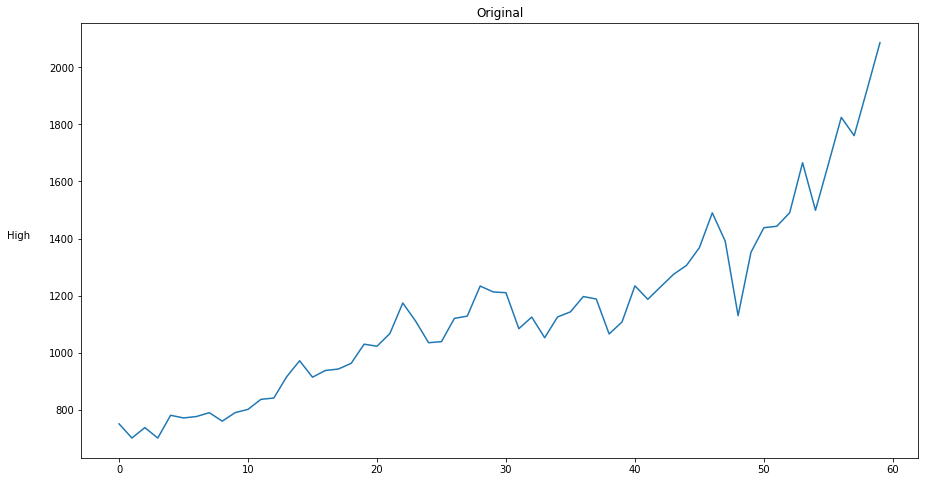

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title('Original')
plt.ylabel('High', rotation=0, labelpad=30)
df['High'].plot()

<Figure size 1080x1440 with 0 Axes>

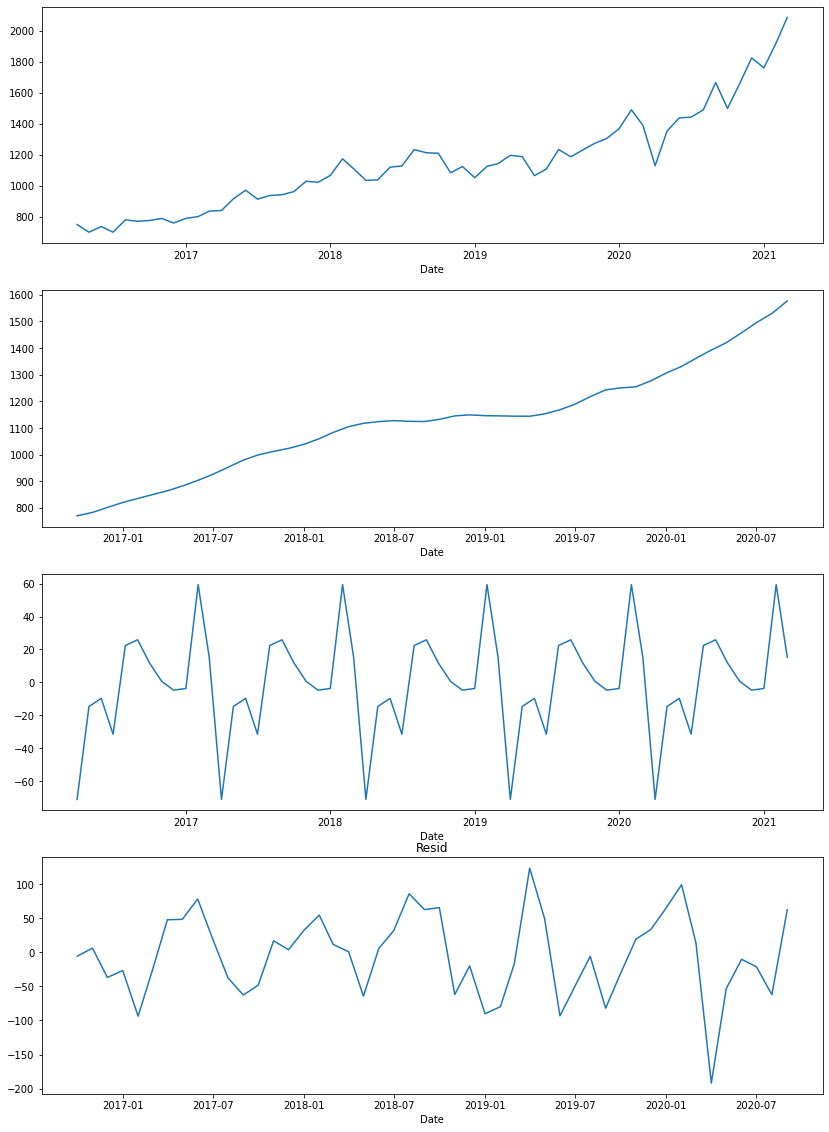

In [15]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15, 20))
decomposition = seasonal_decompose(google_price['High'], period=12)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

plt.title('Observed')
decomposition.observed.plot(ax=ax[0])

plt.title('Trend')
decomposition.trend.plot(ax=ax[1])

plt.title('Seasonal')
decomposition.seasonal.plot(ax=ax[2])

plt.title('Resid')
decomposition.resid.plot(ax=ax[3]);